In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

### 1. Définition du modéle du jeu
En premier, et dans cette partie ,on commence par implémenter un environnement de reinforcement learning pour notre jeu en utilisant la librairie "gym" de Python.

L'environnement contient deux paramètres principaux: la probabilité de gagner un pari (p) et la cible à atteindre (N). Le but du jeu est d'atteindre la cible en pariant avec une certaine quantité de jetons.

La classe GamblerEnv définit les méthodes nécessaires pour l'initialisation, la prise d'une action et le calcul de la récompense. 

Elle utilise un espace d'états discret et un espace d'actions restreint à N/2 au maximum. Il y a également trois types d'initialisation pour la position initiale du joueur: soit avec la moitié des jetons, soit avec 1/3 des jetons, soit avec 2/3 des jetons.

La méthode reset(typee) réinitialise l'environnement en retournant l'état initial. La méthode step(action) prend une action en tant qu'entrée, met à jour l'état et retourne le nouvel état, la récompense, un booléen indiquant si l'état est final et des informations supplémentaires. La méthode render() affiche l'état actuel.

In [2]:
import gym
import numpy as np

class GamblerEnv(gym.Env):
    def __init__(self, p, N):
        self.p = p  # Probabilité de gagner un pari
        self.N = N  # la Target à atteindre
        self.observation_space = gym.spaces.Discrete(N+1)  # l'espace d'états
        self.action_space = gym.spaces.Discrete(N//2+1)  # l'espace d'actions restreint à N/2 au maximum
        self.reward_range = (0, 1)  # Deux récompenses possible, 0 ou 1
        
    def reset(self, typee): 
      # on a 3 types differents d'initialisations, 1 : soit on commence à la moitié , 2 : On commence avec 1/3 des jetons, 3 :  on commence avec 2/3 des jetons
      if(typee == 1) :
        self.state = self.N // 2  # On debute avec la moitié des jetons en notre possession.
      else : 
        if(typee == 2) : 
          self.state = self.N // 3  # On debute avec 1/3 des jetons en notre possession.
        else : 
          self.state = ( self.N * 2) // 3  # On debute avec 2/3 des jetons en notre possession.  
      return self.state
    
    def step(self, action):
        assert self.action_space.contains(action)
        assert self.observation_space.contains(self.state)

        if self.state == 0 or self.state == self.N: # si état final, on ne fait aucune action.
            return self.state, 0, True, {}

        if np.random.random() < self.p: # On tire au hasard un nombre entre 0 et 1 et on le compare à P
            self.state += action     # Dans le cas ou le joueur gagne le pari
        else:
            self.state -= action  # Dans le cas ou le joueur perds le pari

        reward = 1 if self.state == self.N else 0  # On mets le reward à 1 seulement si on atteinds l'état N ( target )
        done = self.state == 0 or self.state == self.N
        return self.state, reward, done, {}

    def render(self): # Affiche juste l'état actuel.
        print(f'State: {self.state}')    


### 2. Simulation d'un episode avec la stratégie BOLD
Cette partie du code implémente une simulation d'un épisode du jeu.

Tout d'abord, un environnement de Gambler est initialisé avec une probabilité de gagner un pari (p) et une cible (N) .
L'état initial est également défini en appelant la méthode reset() de la classe GamblerEnv avec le paramètre typee qui détermine la position initiale du joueur (ici, typee=1 indique que le joueur commence avec la moitié des jetons).

Ensuite, une boucle while est utilisée pour simuler les étapes successives de l'épisode jusqu'à ce que l'état final soit atteint (done=True).

À chaque étape, l'état actuel est affiché à l'aide de la méthode render() de la classe GamblerEnv.


In [3]:
# Initialisation
env = GamblerEnv(p=0.3, N = 12)
state = env.reset(typee = 1)
done = False
total_reward = 0

# Simulation de l'épisode
while not done:
    env.render()
    # Sélection de l'action en suivant la politique "bold"
    action = min(state, env.N - state)
    new_state, reward, done, _ = env.step(action)
    total_reward += reward
    state = new_state
    
print("Episode terminé. État final :", state, "Total des récompenses :", total_reward)

State: 6
Episode terminé. État final : 0 Total des récompenses : 0


### 3. Simulation d'un episode avec la stratégie TIMIDE
Meme logique que la section précedente.

In [4]:
# Initialisation
env = GamblerEnv(p=0.78, N = 12)
state = env.reset(typee = 1)
done = False
total_reward = 0

# Simulation de l'épisode
while not done:
    env.render()
    # Sélection de l'action en suivant la politique "TIMIDE"
    action = 1
    new_state, reward, done, _ = env.step(action)
    total_reward += reward
    state = new_state
    
print("Episode terminé. État final :", state, "Reward :", total_reward)

State: 6
State: 7
State: 8
State: 7
State: 6
State: 7
State: 8
State: 9
State: 10
State: 11
Episode terminé. État final : 12 Reward : 1


### 4. Evaluation et comparaison des politiques par MONTE-CARLO
Cette section nous permettra d'évaluer une politique spécifique en utilisant la technique de Monte Carlo. La mesure de performance de la politique sera déterminée par la valeur de l'état initial de départ.

In [5]:
# cette fonction permets de lancer une evaluation MONTE CARLO d'une politique choisis et retourne le vecteur des valeurs des etats.
def eval_state_values_policy_with_MC(env, policy_name, nb_iter, alpha, gamma, typee):
    """
    Parametres
        env : environnement
        policy_name : nom de la politique ('timide' ou 'bold')
        nb_iter : nombre d'épisodes
        alpha : pas d'apprentissage
        gamma : discount du MDP
        typee : le type d'initialisation souhaité
    Retours
        V : dictionnaire contenant les valeurs-état pour chaque état de l'environnement
    """
    V = defaultdict(float)  # initialisation de la fonction de valeur

    for i in range(nb_iter):
        episode = []
        state = env.reset(typee)
        terminal = False

        while not terminal:
            if policy_name == 'timide':
                action = 1  # la politique timide parie toujours 1
            elif policy_name == 'bold':
                action = min(state, env.N - state)  # la politique bold parie sur le minimum entre i et (N-i)
            else:
                raise ValueError("Nom de politique non valide")

            next_state, reward, terminal, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        G = 0  # initialisation du retour de la fin de l'épisode
        for j, (state, action, reward) in enumerate(reversed(episode)):
            G = gamma * G + reward  # calcul du retour actualisé
            # Ajout de la valeur de V(0) si l'état est 0
            V[state] = V[state] + alpha(i) * (G - V[state])  # mise à jour de la valeur-état  

    return V

In [7]:
# Cette methode permets de comparer entre les deux politique timide et bold suivant une mesure MC
def compare_politiques_MC(nb_iter, alpha, gamma, typee) : 

  V_timide = defaultdict(float) # Initialisation de la fonction de valeur timide
  V_bold = defaultdict(float) # Initialisation de la fonction de valeur bold

  p_values = np.arange(0.1, 1.0, 0.1) # on fait varier les probabilité de 0.1 à 1 avec un pas de 0.1
  valeurs_bold = [] # les valeurs de la politique bold
  valeurs_timides = [] # les valeurs de la politique timide

  N = 12
  if( typee == 1) :
    start_state = N//2
  if(typee == 2) :
     start_state = N//3
  if(typee == 3) : 
      start_state = (N*2)//3

  for p in p_values:
    env =   GamblerEnv(p, N = 12)

    # Evaluation de la fonction de valeur avec MC pour la politique timide
    V_timide = eval_state_values_policy_with_MC(env, 'timide', nb_iter, alpha, gamma, typee)
    valeurs_timides.append(V_timide[start_state]) # on stock la valeur pour cette probabilité p
  

    # Evaluation de la fonction de valeur avec MC pour la politique bold
    V_bold= eval_state_values_policy_with_MC(env, 'bold', nb_iter, alpha, gamma, typee)
    valeurs_bold.append(V_bold[start_state]) # on stock la valeur pour cette probabilité p


# Affichage
  plt.plot(p_values, valeurs_timides, label='Timide')
  plt.plot(p_values, valeurs_bold, label='Bold')
  plt.xlabel('Nombre d\'itérations')
  plt.ylabel('Valeur de la politique')
  plt.title('Comparaison des politiques Bold et Timide')
  plt.legend()
  plt.show()



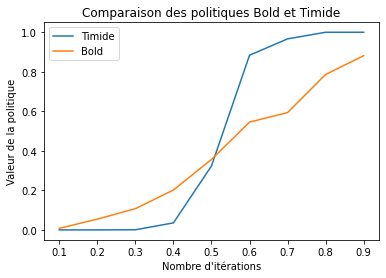

In [8]:
# Exemple d'execution
nb_iter = 100000 # Nombre d'itérations pour l'évaluation de la fonction de valeur
alpha = lambda x: 0.01 # pas d'apprentissage
gamma = 1 # Facteur de discount toujours à 1
typee = 2 # le type d'initialisation ( ici en possession de 1/3 des jetons)
compare_politiques_MC(nb_iter, alpha, gamma, typee)

### 4.2 Discussion des résultats 
Les résultats démontrent de manière évidente la théorie présentée dans l'article. Le graphique montre clairement que lorsque la probabilité de gagner un pari (p) varie de 0,1 à 0,99, la politique bold offre un meilleur rendement et est donc optimale pour la première plage de p (0,1 à 0,49), tandis que la politique timide est optimale pour la plage suivante de p (0,51 à 0,99) car elle maximise la valeur du jeu. Les deux courbes se chevauchent lorsque p est égal à 0,5, ce qui signifie qu'elles ont la même valeur de retour à ce stade.

### 5. Evaluation et comparaison des politiques par TD LEARNING
De même que pour l'algorithme de Monte Carlo, nous appliquons également l'algorithme TD Learning afin de vérifier si nous obtenons les mêmes résultats avec une autre méthode.

In [9]:
# cette fonction fait une estimation d'une politique donné par TD et retourne le vecteur des valeurs V
def eval_state_values_policy_with_TD(env, policy_name, nb_iter, alpha, gamma):
    """
    TD learning "évaluation de chaque visite" pour évaluer les valeurs-état d'une politique
    Params
        env : environnement 
        policy : la politique à mesurer
        nb_iter : nbre épisodes
        alpha : par d'apprentissage
        gamma : le discount
    Returns
      V :  le vecteur V des valeurs
    """
    V = defaultdict(float)  # initialisation de la fonction de valeur
    for i in range(nb_iter):
        state = env.reset(1)
        terminal = False

        while not terminal:
            if policy_name == 'timide':
                action = 1  # la politique timide parie toujours 1
            elif policy_name == 'bold':
                action = min(state, env.N - state)  # la politique bold parie sur le minimum entre i et (N-i)
            else:
                raise ValueError("Nom de politique non valide")

                
            next_state, reward, terminal, _ = env.step(action)

            # Mise à jour de la fonction de valeur pour l'état courant
            V[state] = V[state] + alpha(i) * (reward + gamma * V[next_state] - V[state])

            state = next_state

    return V


In [10]:
# Cette methode permets de comparer entre les deux politique timide et bold suivant une mesure TD
def compare_politiques_TD(nb_iter, alpha, gamma) : 

  V_timide = defaultdict(float) # Initialisation de la fonction de valeur timide
  V_bold = defaultdict(float) # Initialisation de la fonction de valeur bold

  p_values = np.arange(0.1, 1.0, 0.1) # on fait varier les probabilité de 0.1 à 1 avec un pas de 0.1
  valeurs_bold = [] # les valeurs de la politique bold
  valeurs_timides = [] # les valeurs de la politique timide

  for p in p_values:

    env =   GamblerEnv(p, N = 12)

    # Evaluation de la fonction de valeur avec TD pour la politique timide
    V_timide = eval_state_values_policy_with_TD(env, 'timide', nb_iter, alpha, gamma)
    valeurs_timides.append(V_timide[6]) # on stock la valeur pour cette probabilité p
  

    # Evaluation de la fonction de valeur avec TD pour la politique bold
    V_bold= eval_state_values_policy_with_TD(env, 'bold', nb_iter, alpha, gamma)
    valeurs_bold.append(V_bold[6]) # on stock la valeur pour cette probabilité p

# Affichage
  plt.plot(p_values, valeurs_timides, label='Timide')
  plt.plot(p_values, valeurs_bold, label='Bold')
  plt.xlabel('Nombre d\'itérations')
  plt.ylabel('Valeur de la politique')
  plt.title('Comparaison des politiques Bold et Timide')
  plt.legend()
  plt.show()


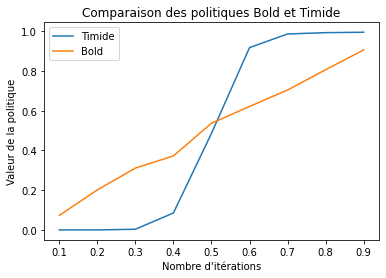

In [11]:
# Exemple d'execution
nb_iter = 10000 # Nombre d'itérations pour l'évaluation de la fonction de valeur
alpha = lambda x: 0.01 # Fonction qui définit le pas d'apprentissage en fonction du temps
gamma = 1 # Facteur de discount
compare_politiques_TD(nb_iter, alpha, gamma)

### 5.2 Discussion des résultats
Comme prévu, nous avons obtenu exactement les mêmes résultats avec quelques imprécisions mineures, principalement en raison d'un nombre d'itérations insuffisant. Cependant, il est certain que les deux algorithmes convergent vers le même résultat, qui a été expliqué précédemment.

### 6. Comparaison entre la technique MC et TD
Dans cette section, nous souhaitons comparer les résultats obtenus par l'algorithme Monte Carlo et TD Learning. Pour ce faire, nous avons choisi d'afficher l'évolution de la fonction de valeur d'une politique donnée (timide ou bold) en fonction du nombre d'itérations pour chacun des deux algorithmes.

In [15]:
# En dernier, on a voulu voir est ce que les deux methodes MC et TD nous donneent des resultats qui sont semblables
# Cette fonction permets de comparer ces derniers
def compare_MC_TD(nb_iter, alpha, gamma, policy_name) : 

  V_MC = defaultdict(float) # Initialisation de la fonction de valeur MC
  V_TD = defaultdict(float) # Initialisation de la fonction de valeur TD

  p_values = np.arange(0.1, 1.0, 0.1) # on fait varier les probabilité de 0.1 à 1 avec un pas de 0.1
  valeurs_MC = [] # les valeurs de MC
  valeurs_TD = [] # les valeurs de TD

  for p in p_values:

    env =   GamblerEnv(p, N = 12)
    if policy_name == 'timide' :
      # Evaluation de la fonction de valeur avec TD pour la politique timide
      V_TD = eval_state_values_policy_with_TD(env, 'timide', nb_iter, alpha, gamma)
      valeurs_TD.append(V_TD[6]) # on stock la valeur pour cette probabilité p
    

      # Evaluation de la fonction de valeur avec MC pour la politique timide
      V_MC= eval_state_values_policy_with_MC(env, 'timide', nb_iter, alpha, gamma, 1)
      valeurs_MC.append(V_MC[6]) # on stock la valeur pour cette probabilité p
    else : 
      # Evaluation de la fonction de valeur avec TD pour la politique bold
      V_TD = eval_state_values_policy_with_TD(env, 'bold', nb_iter, alpha, gamma)
      valeurs_TD.append(V_TD[6]) # on stock la valeur pour cette probabilité p
    

      # Evaluation de la fonction de valeur avec MC pour la politique bold
      V_MC= eval_state_values_policy_with_MC(env, 'bold', nb_iter, alpha, gamma, 1)
      valeurs_MC.append(V_MC[6]) # on stock la valeur pour cette probabilité p

# Affichage
  plt.plot(p_values, valeurs_TD, label='TD Learning')
  plt.plot(p_values, valeurs_MC, label='MONTE CARLO')
  plt.xlabel('Nombre d\'itérations')
  plt.ylabel('Valeur de la politiques ' + policy_name)
  plt.title('Comparaison des techniques MONTE CARLO et TD')
  plt.legend()
  plt.show()


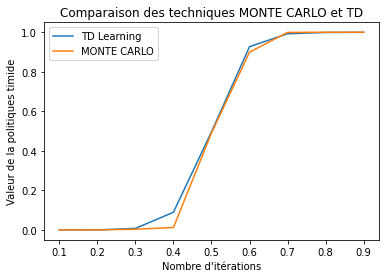

In [16]:
# Executions
nb_iter = 100000 # Nombre d'itérations pour l'évaluation de la fonction de valeur
alpha = lambda x: 0.01 # Fonction qui définit le pas d'apprentissage en fonction du temps
gamma = 1 # Facteur de discount
compare_MC_TD(nb_iter, alpha, gamma, 'timide') 

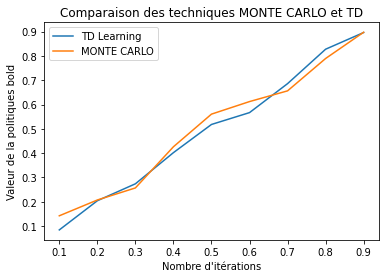

In [17]:
# Execution
nb_iter = 100000 # Nombre d'itérations pour l'évaluation de la fonction de valeur
alpha = lambda x: 0.01 # Fonction qui définit le pas d'apprentissage en fonction du temps
gamma = 1 # Facteur de discount
compare_MC_TD(nb_iter, alpha, gamma, 'bold') 

### 6.2  Discussion Résultats
Comme prévu, les deux algorithmes ont donné des résultats très similaires avec de légères différences qui peuvent être attribuées au nombre d'itérations insuffisant. Ces résultats confirment les conclusions présentées précédemment.

### 7. Influence de l'etat initial sur les politiques
Dans cette partie, on veut voir si vraiment comme montré dans l'article, la politique Timide est optimal pour P > 0.5 et la politique bold optimal pour P < 0.5 et ce quelque soit l'état de depart du MDP.
Pour faire ca, on compare entre les valeurs des politiques avec une initialisation : 


1.   La moitier des jetons en la possession du joueur
2.   Un tier des jetons en la possession du joueur
3.   Deux tiers des jetons en la possession du joueur

Nous Utilisons un algorithme MONTE CARLO pour la comparaison.

In [18]:
# Cette methode permets de comparer entre les deux politique timide et bold suivant une mesure MC
def compare_politique_MC_types(nb_iter, alpha, gamma) : 

  V_timide_1 = defaultdict(float) # Initialisation de la fonction de valeur timide type 1
  V_bold_1 = defaultdict(float) # Initialisation de la fonction de valeur bold type 1
  V_timide_2 = defaultdict(float) # Initialisation de la fonction de valeur timide type 2
  V_bold_2 = defaultdict(float) # Initialisation de la fonction de valeur bold type 2
  V_timide_3 = defaultdict(float) # Initialisation de la fonction de valeur timide type 3
  V_bold_3 = defaultdict(float) # Initialisation de la fonction de valeur bold type 3

  p_values = np.arange(0.1, 1.0, 0.1) # on fait varier les probabilité de 0.1 à 1 avec un pas de 0.1
  valeurs_bold_1 = [] # les valeurs de la politique bold type 1
  valeurs_timides_1 = [] # les valeurs de la politique timide type 1
  valeurs_bold_2 = [] # les valeurs de la politique bold type 2
  valeurs_timides_2 = [] # les valeurs de la politique timide type 2
  valeurs_bold_3 = [] # les valeurs de la politique bold type 3
  valeurs_timides_3 = [] # les valeurs de la politique timide type 3

  N = 12

  for p in p_values:
    env =   GamblerEnv(p, N = 12)

    # Evaluation de la fonction de valeur avec MC pour la politique timide
    V_timide_1 = eval_state_values_policy_with_MC(env, 'timide', nb_iter, alpha, gamma, 1)
    valeurs_timides_1.append(V_timide_1[6]) # on stock la valeur pour cette probabilité p
  

    # Evaluation de la fonction de valeur avec MC pour la politique bold
    V_bold_1= eval_state_values_policy_with_MC(env, 'bold', nb_iter, alpha, gamma, 1)
    valeurs_bold_1.append(V_bold_1[6]) # on stock la valeur pour cette probabilité p

  for p in p_values:
    env =   GamblerEnv(p, N = 12)

    # Evaluation de la fonction de valeur avec MC pour la politique timide
    V_timide_2 = eval_state_values_policy_with_MC(env, 'timide', nb_iter, alpha, gamma, 2)
    valeurs_timides_2.append(V_timide_2[4]) # on stock la valeur pour cette probabilité p
  

    # Evaluation de la fonction de valeur avec MC pour la politique bold
    V_bold_2= eval_state_values_policy_with_MC(env, 'bold', nb_iter, alpha, gamma, 2)
    valeurs_bold_2.append(V_bold_2[4]) # on stock la valeur pour cette probabilité p  

  for p in p_values:
    env =   GamblerEnv(p, N = 12)

    # Evaluation de la fonction de valeur avec MC pour la politique timide
    V_timide_3 = eval_state_values_policy_with_MC(env, 'timide', nb_iter, alpha, gamma, 3)
    valeurs_timides_3.append(V_timide_3[8]) # on stock la valeur pour cette probabilité p
  

    # Evaluation de la fonction de valeur avec MC pour la politique bold
    V_bold_3= eval_state_values_policy_with_MC(env, 'bold', nb_iter, alpha, gamma, 3)
    valeurs_bold_3.append(V_bold_3[8]) # on stock la valeur pour cette probabilité p    


# Affichage
  plt.figure(figsize=(8, 12))

  plt.subplot(3, 1, 1)
  plt.plot(p_values, valeurs_timides_1, label='Timide type 1')
  plt.plot(p_values, valeurs_bold_1, label='Bold type 1')
  plt.xlabel('Nombre d\'itérations')
  plt.ylabel('Valeur de la politique')
  plt.legend()
  plt.title('Comparaison des politiques Bold et Timide initialisation 1')

  plt.subplot(3, 1, 2)  
  plt.plot(p_values, valeurs_timides_2, label='Timide type 2')
  plt.plot(p_values, valeurs_bold_2, label='Bold type 2')
  plt.xlabel('Nombre d\'itérations')
  plt.ylabel('Valeur de la politique')
  plt.legend()
  plt.title('Comparaison des politiques Bold et Timide initialisation 2')

  plt.subplot(3, 1, 3)
  plt.plot(p_values, valeurs_timides_3, label='Timide type 3')
  plt.plot(p_values, valeurs_bold_3, label='Bold type 3')
  plt.xlabel('Nombre d\'itérations')
  plt.ylabel('Valeur de la politique')
  plt.title('Comparaison des politiques Bold et Timide initialisation 3')
  plt.legend()
  plt.tight_layout()  # Pour s'assurer que les graphiques ne se chevauchent pas
  plt.show()




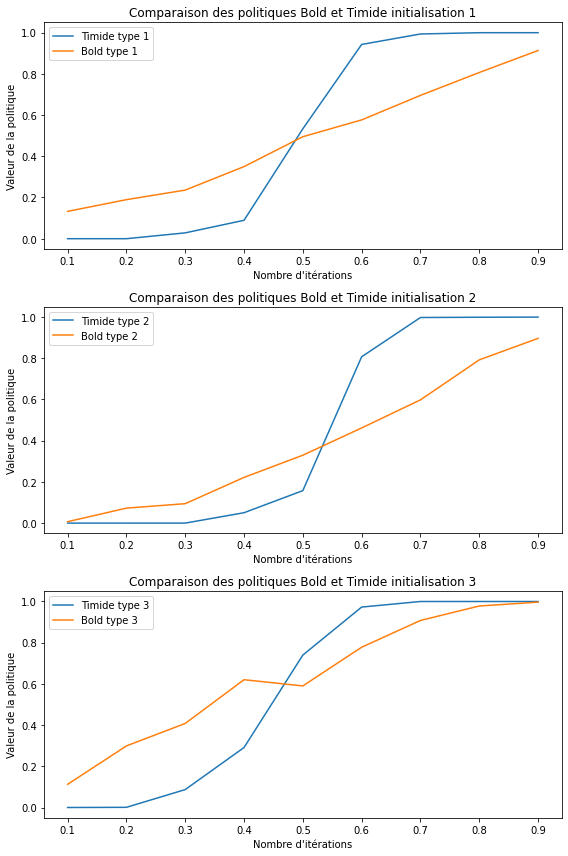

In [19]:
# Exemple d'execution
nb_iter = 50000 # Nombre d'itérations pour l'évaluation de la fonction de valeur
alpha = lambda x: 0.01 # pas d'apprentissage
gamma = 1 # Facteur de discount toujours à 1
compare_politique_MC_types(nb_iter, alpha, gamma)

# Discussion
On remarque, des résultats précedent, que changer l'initialisation n'affecte pas la politique optimale. Seul le paramètre p influe sur l'optimalité de la politique timide ou bold. En revanche, commencer à partir d'un point de départ i inférieur à N/2 diminue la probabilité globale d'atteindre N, mais n'affecte pas la politique qui maximise cette probabilité. De même, commencer à partir d'un point de départ i supérieur à N/2 augmente la probabilité d'atteindre N, mais la meilleure politique pour maximiser cette probabilité ne change pas.
Ces résultats confirment une fois de plus les conclusions présentées dans l'article.